#### If yfinance is not already installed, uncomment the code block below, and run

In [1]:
#!pip install yfinance


In [2]:
import yfinance as yf  
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
from datetime import datetime

In [3]:
now = datetime.now()

In [9]:
now = str(now.year)+"-"+str(now.month)+"-"+str(now.day)


2020-7-1


In [ ]:
def ge

[*********************100%***********************]  1 of 1 completed


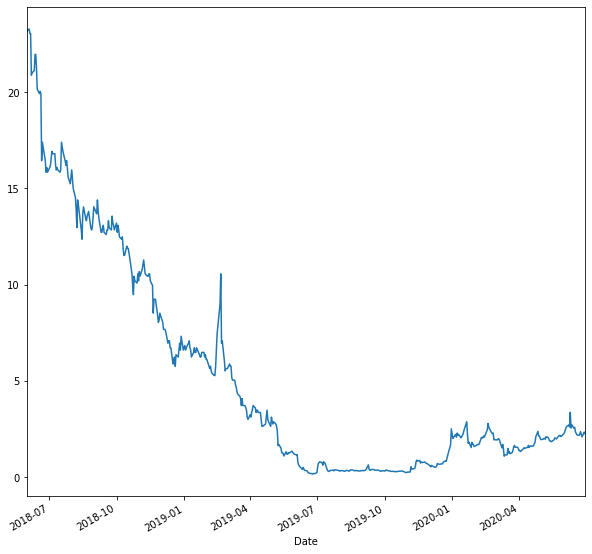

In [12]:
# Get the data for the stock Apple by specifying the stock ticker, start date, and end date
data = yf.download('FCEL','2018-06-01',now)
plt.figure(figsize=(10,10))
# Plot the close prices
data.Close.plot()
plt.show()

In [14]:
data.sort_values('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-01,22.559999,23.280001,22.559999,23.160000,23.160000,55800
2018-06-04,23.400000,23.760000,22.799999,23.280001,23.280001,52700
2018-06-05,23.639999,23.639999,22.920000,23.040001,23.040001,40900
2018-06-06,23.400000,23.400000,22.920000,23.040001,23.040001,52600
2018-06-07,22.200001,22.200001,20.520000,20.879999,20.879999,211400
2018-06-08,21.240000,21.600000,20.879999,21.000000,21.000000,61500
2018-06-11,20.879999,21.120001,20.520000,21.120001,21.120001,68200
2018-06-12,21.240000,22.200001,21.000000,21.959999,21.959999,82000
2018-06-13,22.080000,22.200001,21.480000,21.959999,21.959999,58800


In [324]:
tickers = ['BX','NVDA']


stock_data = []
for tick in tickers:
    _ = yf.download(tick,'2018-01-01','2020-06-22')
    
    _['Ticker'] = tick
    stock_data.append(_)

frame = pd.concat(stock_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [327]:
PENN = frame[frame['Ticker']=='BX']
PENN

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2018-01-02,32.380001,33.060001,32.299999,32.520000,27.299517,5241100,BX
2018-01-03,32.700001,33.299999,32.700001,33.000000,27.702465,6720800,BX
2018-01-04,33.230000,33.500000,33.150002,33.259998,27.920721,3939300,BX
2018-01-05,33.439999,33.549999,32.910000,33.009998,27.710855,3525900,BX
2018-01-08,33.000000,33.340000,32.959999,33.279999,27.937511,3231200,BX
2018-01-09,33.459999,33.900002,33.459999,33.740002,28.323671,5443200,BX
2018-01-10,33.770000,34.549999,33.500000,34.180000,28.693037,11147700,BX
2018-01-11,34.320000,34.830002,34.259998,34.529999,28.986849,6183400,BX
2018-01-12,35.430000,35.580002,34.950001,35.389999,29.708790,10429400,BX


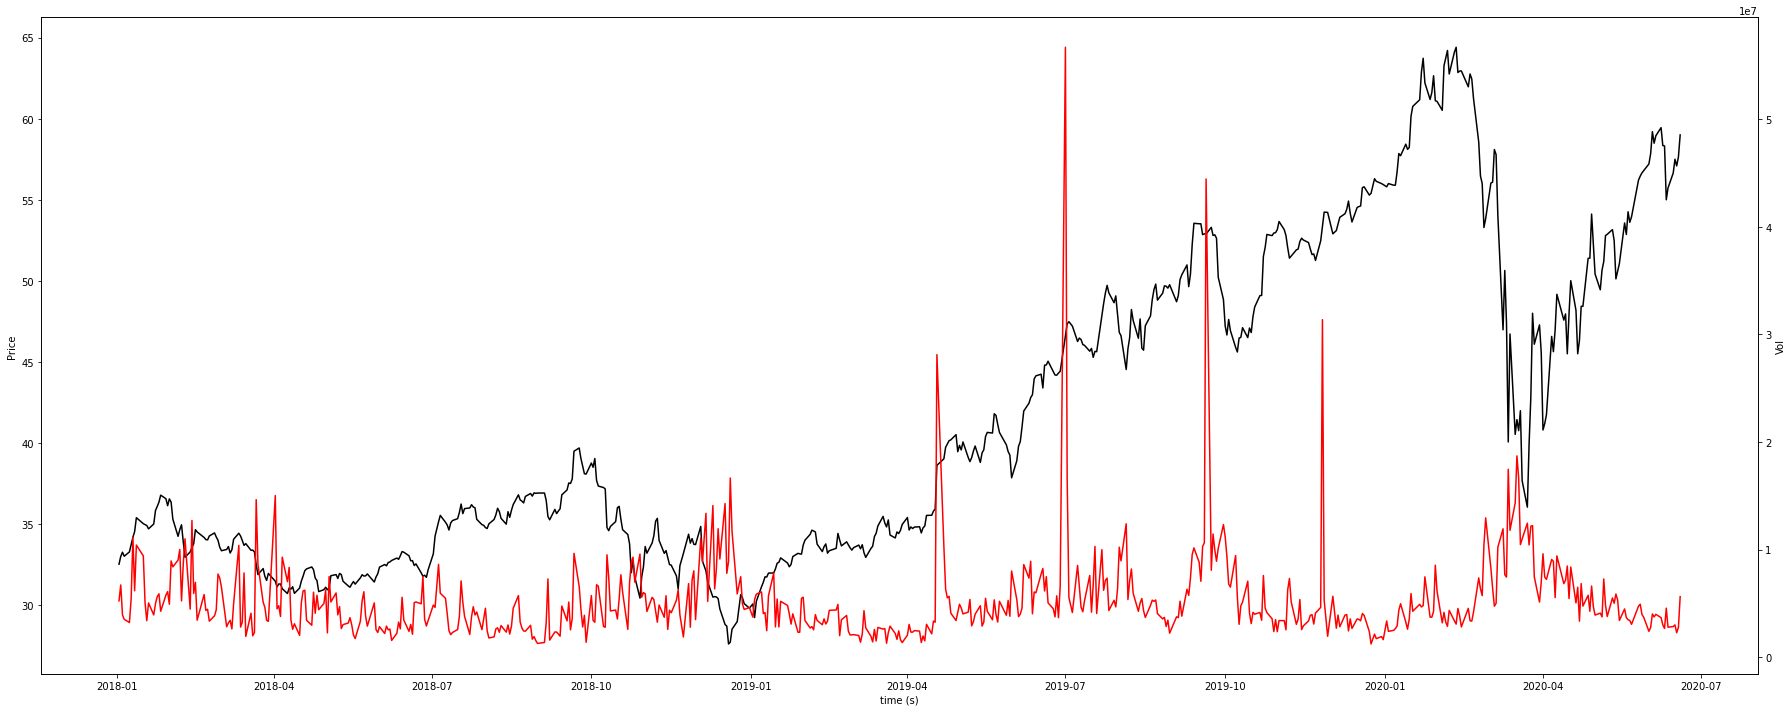

In [328]:
fig, ax1 = plt.subplots(figsize=(25,10))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Price')
ax1.plot(PENN['Close'],c='k')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Vol')  # we already handled the x-label with ax1
ax2.plot(PENN['Volume'],c='r')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [124]:
# For data manipulation
import pandas as pd

# To extract fundamental data
from bs4 import BeautifulSoup as bs
import requests

In [329]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers = ['BX','NVDA','DOCU']
results = {}

with requests.Session() as s:

    for ticker in tickers:
        r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
        data = json.loads(p.findall(r.text)[0])
        key_stats = data['context']['dispatcher']['stores']['QuoteSummaryStore']
        results.setdefault(ticker,[])
        results[ticker]
        try:
            res = {'EnterPrise Value' :key_stats['defaultKeyStatistics']['enterpriseValue']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'EnterPrise Value':np.nan})
            
        try:
            res = {'Trailing P/E' : key_stats['summaryDetail']['trailingPE']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'Trailing P/E':np.nan})
            
        try:
            res = {'Forward P/E' : key_stats['summaryDetail']['forwardPE']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'Forward P/E':np.nan})
            
            
        try:
            res = {'PEG Ratio (5 yr expected)' : key_stats['defaultKeyStatistics']['pegRatio']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'PEG Ratio (5 yr expected)':np.nan})
            
        try:
            res = {'Return on Assets' : key_stats['financialData']['returnOnAssets']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({"Return on Assets":np.nan})
            
        try:
            res = {'Quarterly Revenue Growth' : key_stats['financialData']['revenueGrowth']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({"Quarterly Revenue Growth":np.nan})
            
        res = {'Company' : ticker}
        results[ticker].append(res)    
            
        

In [330]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers = ['BX','NVDA','DOCU']
q_results = {}
main_keys = ['trailingPsRatio', 
             'quarterlyPbRatio', 
             'quarterlyForwardPeRatio',
             'quarterlyMarketCap', 
             'quarterlyPeRatio', 
             'trailingMarketCap',
             'trailingEnterprisesValueEBITDARatio',
             'quarterlyEnterprisesValueEBITDARatio', 
             'trailingForwardPeRatio', 
             'trailingEnterpriseValue',
             'trailingPeRatio', 
             'quarterlyEnterprisesValueRevenueRatio', 
             'quarterlyPsRatio', 
             'trailingEnterprisesValueRevenueRatio', 
             'quarterlyPegRatio', 
             'trailingPbRatio',
             'quarterlyEnterpriseValue', 
             'trailingPegRatio', 
             'timestamp']

with requests.Session() as s:

    for ticker in tickers:
        r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
        data = json.loads(p.findall(r.text)[0])
        
        key_stats = data['context']['dispatcher']['stores']['QuoteTimeSeriesStore']
        
        q_results.setdefault(ticker,[])
        for mk in main_keys:
            try:
                res = {mk: key_stats['timeSeries'][mk][1]['reportedValue']['raw']}
                
                q_results[ticker].append(res)
            except:
                q_results[ticker].append({mk:np.nan})
            
        res = {'Company' : ticker}
        q_results[ticker].append(res)  
            
                
                
                
        

In [331]:
finstats = {}

for k in results.keys():
    c = results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats.setdefault(key,[])
            finstats[key].append(val)
    
            

In [332]:
fstat = pd.DataFrame(finstats)

In [333]:
finstats_q = {}

for k in q_results.keys():
    c = q_results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats_q.setdefault(key,[])
            finstats_q[key].append(val)
    

In [334]:
fstatsq = pd.DataFrame(finstats_q)

In [335]:
full_df = pd.merge(fstat,fstatsq,on='Company')
full_df_transpose=full_df.T
full_df_transpose.columns = list(full_df['Company'])

In [336]:
full_df_transpose

,BX,NVDA,DOCU
EnterPrise Value,55.15B,219.05B,29.54B
Trailing P/E,297.43,71.24,NaN
Forward P/E,19.39,38.57,200.36
PEG Ratio (5 yr expected),2.20,3.06,10.84
Return on Assets,0.65%,11.62%,-6.59%
Quarterly Revenue Growth,NaN,38.70%,38.80%
Company,BX,NVDA,DOCU
trailingPsRatio,20.9264,19.485,13.2486
quarterlyPbRatio,4.53624,10.5885,15.226
quarterlyForwardPeRatio,18.2149,32.2581,NaN
